### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- The model can be applied to normal dynamic pipelay condition as a rough estimate

In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate
import plotly.graph_objects as go

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

### Modelling data:

In [5]:
mp = 179.7       #  (submerged pipe weight) [kg/m]
N = 20       # number of modelling nodes

In [6]:
mi = [mp for i in range(N)]

In [7]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 168 # [m]
B = 46
H = 13.5
Xg = L/2 # [m]
mn = 39_989_000  # mass of the vessel, [kg]

In [8]:
Fx_0 = 1515*1000
Fy_0 = 0.7*Fx_0
LTD = 209

In [9]:
lx, ly, lz = L/2, B/2, H/2

In [10]:
vessel_mass = mn/L # mass over length of the vessel

In [11]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.508 # Outer diameter of pipe, [m]
dI= (508-33*2)/1000 # Inner diameter of pipe, [m]

In [13]:
rho_steel=7850 #kg/m^3
rho_steel *= 9.81

In [14]:
Ar=np.pi*((d0/2)**2-(dI/2)**2) 
Iy_ = 1/4*np.pi*rho_steel*((d0/2)**4-(dI/2)**4)
Iz_ = 1/2*np.pi*rho_steel*((d0/2)**4-(dI/2)**4)
J_ = 1/32*np.pi*(d0**4-dI**4)

In [15]:
E = 207e9
G = 79.3e9

In [16]:
h = 34 # water depth

In [17]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [18]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [19]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [20]:
# Constants: 

In [21]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [22]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [23]:
# diag_CR = 1e11*np.array([1, 1, 1]) 
diag_CR = 1e7*np.array([1, 1, 1])                ### !!! ### !!! ### !!! ###
CR=np.diag(diag_CR)

In [24]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [25]:
# for testing:

In [26]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [27]:
φ

array([0.0589748 , 0.66666664, 0.08423931, 0.08506608, 0.33664261,
       0.6855677 , 0.13503953, 0.00194293, 0.36758152, 0.19506881,
       0.46780659, 0.4944074 , 0.50982639, 0.57465643, 0.85084796,
       0.26712202, 0.63315804, 0.9375896 , 0.3925374 , 0.82837443])

In [28]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [29]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [30]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [31]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

In [32]:
# integration parameters
tspan = (0., 12)

coefs = [1, 1, 1, 1, 1, 1]
k500 = 6
lift_reduction_factor=1
vessel_motion_calibration_coefficient = 1e2 # to control dynamics

### Main functions:

In [33]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [34]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [35]:
Π(φ,θ,ψ)

array([[[ 0.54081989,  0.        ,  0.8396761 ],
        [ 0.        ,  1.        , -0.05894062],
        [-0.84113842,  0.        ,  0.53987967]],

       [[ 0.67030354,  0.        ,  0.58319676],
        [ 0.        ,  1.        , -0.61836978],
        [-0.74208703,  0.        ,  0.52678303]],

       [[ 0.57321122,  0.        ,  0.816502  ],
        [ 0.        ,  1.        , -0.08413971],
        [-0.81940765,  0.        ,  0.57117859]],

       [[ 0.61514119,  0.        ,  0.7855661 ],
        [ 0.        ,  1.        , -0.08496352],
        [-0.78841697,  0.        ,  0.61291688]],

       [[ 0.95982877,  0.        ,  0.26483682],
        [ 0.        ,  1.        , -0.33032002],
        [-0.28058642,  0.        ,  0.90595262]],

       [[ 0.75451102,  0.        ,  0.50800564],
        [ 0.        ,  1.        , -0.63311255],
        [-0.65628738,  0.        ,  0.58403662]],

       [[ 0.67263401,  0.        ,  0.7332386 ],
        [ 0.        ,  1.        , -0.13462948],
        

In [36]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [37]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 0.57790652, -0.01793387, -0.33628262],
       [ 0.46671688,  0.10070017, -0.43082906],
       [ 0.23245741,  0.35510604, -0.30180197],
       [ 0.65711345,  0.2851127 ,  0.1088442 ],
       [ 0.49531058,  0.26859107,  0.57938351],
       [ 0.15533023, -0.01217363, -0.08313774],
       [ 0.65782085,  0.34710275,  0.54953921],
       [ 0.5227434 ,  0.06479475,  0.53047447],
       [ 1.05936988, -0.13647386,  0.37915354],
       [ 0.83346362,  0.91992771, -0.2768284 ],
       [ 1.05888615,  0.16331597, -0.16788937],
       [ 1.17481069,  0.15411099,  0.00134437],
       [ 0.31708448,  0.18027097,  0.59269443],
       [ 0.91610717, -0.05400949, -0.22885048],
       [ 0.35078184,  0.43155004,  0.04593935],
       [ 1.03457017, -0.02888234,  0.01544437],
       [ 0.95913747,  0.52819696, -0.18757006],
       [ 0.63163321,  0.34717051, -0.03092255],
       [ 1.0216197 ,  0.65355657, -0.36417661],
       [ 0.93762521, -0.06117401,  0.10201255]])

In [38]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [39]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 1.01909917e+00, -4.17427319e-02, -1.17451715e-01],
       [ 1.39360192e+00,  3.67973932e-01, -6.49142371e-01],
       [ 9.34652331e-01,  1.16155500e+00, -3.31846329e-01],
       [ 9.88481648e-01,  5.92962648e-01,  1.14052810e-01],
       [ 1.55185505e+00,  1.02475126e+00,  7.49543020e-01],
       [ 4.05945999e-01,  7.37702722e-02,  1.66587529e-01],
       [ 1.49870472e+00,  3.94880259e-01,  4.36112336e-01],
       [ 5.94854813e-01,  7.10389836e-01,  1.36162340e+00],
       [ 1.91706828e+00,  1.77996647e-03,  4.56242052e-01],
       [ 1.29132618e+00,  1.58951886e+00, -6.57412483e-01],
       [ 1.68074099e+00,  3.26072415e-01, -3.97494982e-01],
       [ 1.32471125e+00, -7.36889065e-02,  2.63782018e-01],
       [ 9.83882338e-01,  7.15967377e-01,  1.02059682e+00],
       [ 1.39501886e+00, -2.65166574e-01,  2.29093172e-01],
       [ 6.66316511e-01,  1.22522185e+00,  2.61092484e-01],
       [ 1.35417366e+00,  4.71577332e-01,  3.59067147e-03],
       [ 1.00948907e+00,  1.05464392e+00

In [40]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [41]:
phi(x,y,z)

array([[0.86579145, 0.79634121, 0.89480265],
       [0.27765841, 0.44675605, 0.49996884],
       [0.65132063, 0.4969113 , 0.70785546],
       [0.5544259 , 0.93898495, 0.45832223],
       [0.15520643, 0.35017978, 0.74082722],
       [0.19670146, 0.38600671, 0.08771393],
       [0.10793326, 0.12050123, 0.7070895 ],
       [0.95427709, 0.44761056, 0.92191042],
       [0.540322  , 0.73494511, 0.70361776],
       [0.38684055, 0.94844493, 0.73695164],
       [0.07652764, 0.36350437, 0.94759   ],
       [0.1947164 , 0.07049557, 0.45101781],
       [0.66302535, 0.14835548, 0.77687457],
       [0.90817861, 0.54932215, 0.73294796],
       [0.32728881, 0.85979822, 0.32085599],
       [0.31289107, 0.58867045, 0.07710526],
       [0.30672893, 0.46100394, 0.34986895],
       [0.76114132, 0.44615016, 0.32176618],
       [0.08902782, 0.15531427, 0.46966245],
       [0.32147441, 0.88729534, 0.02037328]])

In [42]:
theta(φ,θ,ψ)

array([[0.0589748 , 0.99938479, 0.63386044],
       [0.66666664, 0.83617857, 0.69551733],
       [0.08423931, 0.96037687, 0.29360592],
       [0.08506608, 0.90823129, 0.40253425],
       [0.33664261, 0.28440502, 0.99249993],
       [0.6855677 , 0.71588759, 0.41108516],
       [0.13503953, 0.83303368, 0.90907322],
       [0.00194293, 0.0550069 , 0.54178467],
       [0.36758152, 0.44240583, 0.99297382],
       [0.19506881, 0.41313461, 0.63528165],
       [0.46780659, 0.67098519, 0.27069646],
       [0.4944074 , 0.76341072, 0.9793401 ],
       [0.50982639, 0.05326899, 0.27240154],
       [0.57465643, 0.82826251, 0.68265974],
       [0.85084796, 0.90524648, 0.07790094],
       [0.26712202, 0.89288148, 0.00174177],
       [0.63315804, 0.55307039, 0.62879528],
       [0.9375896 , 0.71880527, 0.32266193],
       [0.3925374 , 0.79372419, 0.44017648],
       [0.82837443, 0.33094361, 0.42584916]])

In [43]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [44]:
ω(x,y,z)

array([[ 1.01996036,  0.114852  , -0.21335406],
       [ 0.45814172,  0.30971235,  0.31366896],
       [ 0.84091288,  0.06778298,  0.18437008],
       [ 0.64189324,  0.69769878, -0.21725884],
       [ 0.39688524,  0.2356597 ,  0.63425646],
       [ 0.21461493,  0.3688643 ,  0.00563644],
       [ 0.19165505,  0.04433085,  0.6849026 ],
       [ 1.0909751 , -0.30457243,  0.06751038],
       [ 0.80544338,  0.37299559,  0.08531895],
       [ 0.78004169,  0.67041937,  0.08354685],
       [ 0.40745829,  0.2910583 ,  0.8558695 ],
       [ 0.22540086, -0.0167711 ,  0.4276804 ],
       [ 0.74624476, -0.32981396,  0.50755242],
       [ 1.00998357, -0.02852271, -0.08960808],
       [ 0.44379638,  0.75665042, -0.04971761],
       [ 0.30095959,  0.56493663, -0.1127212 ],
       [ 0.42308248,  0.35536386,  0.16227232],
       [ 0.78716451,  0.2242125 , -0.1182594 ],
       [ 0.16032083,  0.11355646,  0.44839969],
       [ 0.21800226,  0.88085808, -0.23705366]])

In [45]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [46]:
Ret(φ,θ,ψ)

array([[[ 0.46512666, -0.28035912,  0.8396761 ],
        [ 0.59123005,  0.80434634, -0.05894062],
        [-0.65886585,  0.52385659,  0.53987967]],

       [[ 0.80865203, -0.07722328,  0.58319676],
        [ 0.50358297,  0.6033432 , -0.61836978],
        [-0.30411525,  0.79373393,  0.52678303]],

       [[ 0.56863452, -0.09989626,  0.816502  ],
        [ 0.28837947,  0.95381224, -0.08413971],
        [-0.77038436,  0.28330716,  0.57117859]],

       [[ 0.59221579, -0.17934984,  0.7855661 ],
        [ 0.39033474,  0.91674423, -0.08496352],
        [-0.704925  ,  0.35695048,  0.61291688]],

       [[ 0.60225317, -0.75309533,  0.26483682],
        [ 0.79039123,  0.51591704, -0.33032002],
        [ 0.11212863,  0.40826098,  0.90595262]],

       [[ 0.85768809,  0.07938135,  0.50800564],
        [ 0.30931762,  0.70957108, -0.63311255],
        [-0.41072344,  0.70014819,  0.58403662]],

       [[ 0.49191389, -0.46944848,  0.7332386 ],
        [ 0.78175214,  0.60888299, -0.13462948],
        

In [47]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))

    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [48]:
d_s(phi,x,y,z,φ, θ, ψ).T

array([[ 0.62781087, -0.25145433, -0.38367101],
       [ 0.26036893, -0.46185377,  0.2681014 ],
       [ 0.61328844, -0.1396051 , -0.46630432],
       [ 0.23189665, -0.06930833, -0.13852706],
       [-0.3139696 , -0.30920766,  0.21193656],
       [ 0.1209645 , -0.10496522,  0.19065825],
       [ 0.44151876, -0.48093726,  0.0145653 ],
       [-0.19235248,  0.48687853, -0.03728606],
       [-0.4395989 , -0.14541572,  0.48946679],
       [-0.25337937, -0.12554746,  0.29458143],
       [ 0.55709385, -0.4973168 ,  0.14578431],
       [ 0.1149117 , -0.37520556,  0.00903543],
       [-0.09308942, -0.26592455,  0.13022953],
       [ 0.354849  , -0.62685899,  0.03012663],
       [ 0.81981825, -0.39019817,  0.20935981],
       [ 0.19066692, -0.07778778, -0.17983995],
       [ 0.01781267, -0.2513743 ,  0.3156064 ],
       [ 0.35893314, -0.62805021,  0.02177314],
       [ 0.29287528, -0.26498453,  0.03211206],
       [-0.00241382, -0.0168656 ,  0.77261765]])

In [49]:
d_s(theta, φ, θ, ψ, φ, θ, ψ).T

array([[ 3.17366989e-01, -3.40324916e-01,  5.07049930e-01],
       [ 3.89757230e-01, -6.78481901e-01,  4.42108158e-01],
       [ 1.79953851e-01, -7.62511006e-02,  1.97784175e-01],
       [ 1.88661218e-01, -1.33069614e-01,  2.60373664e-01],
       [-2.71972671e-01, -3.10678474e-01,  1.81275686e-01],
       [ 3.37522750e-01, -4.42349711e-01,  2.07446007e-01],
       [ 2.24529866e-01, -6.20204426e-01,  5.34974259e-01],
       [-5.19301118e-04, -1.61382481e-02,  1.64036387e-03],
       [-2.15893477e-01, -4.73802112e-01,  2.91015999e-01],
       [-1.92325548e-02, -1.76387955e-01,  1.20613652e-01],
       [ 2.16782346e-01, -1.87388651e-01,  8.98526689e-02],
       [ 7.80160472e-02, -7.94601870e-01,  5.80019007e-01],
       [-3.29035025e-02, -3.49237886e-02,  6.84116122e-02],
       [ 3.41881427e-01, -5.74102931e-01,  4.08759387e-01],
       [ 6.43088824e-01, -5.86526370e-01, -2.08211604e-01],
       [ 1.86383475e-01, -5.55891206e-02, -8.76318176e-02],
       [ 5.92122734e-02, -4.43691342e-01

In [50]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
#     t1=np.einsum('ijk,kp->ijp',RET, np.array([0,0,1]).reshape(3,1)).squeeze()
    return np.einsum('ijk,ik->ij', A, B 
#                      - t1
                    )

In [51]:
ne(x, y, z, φ, θ, ψ)

array([[ 6.27810869e+08, -2.51454333e+08, -3.83671011e+08],
       [ 2.60368933e+08, -4.61853773e+08,  2.68101398e+08],
       [ 6.13288441e+08, -1.39605104e+08, -4.66304323e+08],
       [ 2.31896652e+08, -6.93083296e+07, -1.38527063e+08],
       [-3.13969604e+08, -3.09207661e+08,  2.11936560e+08],
       [ 1.20964505e+08, -1.04965219e+08,  1.90658246e+08],
       [ 4.41518756e+08, -4.80937265e+08,  1.45653041e+07],
       [-1.92352484e+08,  4.86878534e+08, -3.72860567e+07],
       [-4.39598899e+08, -1.45415719e+08,  4.89466788e+08],
       [-2.53379365e+08, -1.25547462e+08,  2.94581430e+08],
       [ 5.57093848e+08, -4.97316801e+08,  1.45784308e+08],
       [ 1.14911703e+08, -3.75205557e+08,  9.03542600e+06],
       [-9.30894188e+07, -2.65924553e+08,  1.30229530e+08],
       [ 3.54849003e+08, -6.26858988e+08,  3.01266284e+07],
       [ 8.19818254e+08, -3.90198170e+08,  2.09359810e+08],
       [ 1.90666915e+08, -7.77877823e+07, -1.79839951e+08],
       [ 1.78126712e+07, -2.51374299e+08

In [52]:
d_s(ne, x, y, z, φ, θ, ψ).T

array([[-2.95524835e+08,  4.00140136e+08, -7.45823025e+08],
       [ 4.96003862e+07, -2.61969632e+08, -4.99460515e+08],
       [-4.22532795e+08,  1.94819741e+08, -6.14046011e+08],
       [-1.08625472e+08,  9.27142557e+07, -2.28227993e+08],
       [ 2.39613567e+08, -3.76839937e+08, -1.94824426e+08],
       [ 6.48425842e+07, -1.63820597e+08, -1.31329834e+08],
       [ 2.53695786e+08,  2.12368250e+08, -6.78025142e+08],
       [-2.65343587e+08, -1.02852293e+08,  2.58253337e+07],
       [ 1.40775977e+08, -6.55727752e+08, -6.83767695e+07],
       [ 1.47257111e+08, -2.51123076e+08,  1.96348033e+07],
       [ 2.94820930e+07, -1.31931321e+08, -5.62721434e+08],
       [ 1.08130842e+08,  2.36771588e+07, -3.91979046e+08],
       [ 4.55426175e+07, -8.75235088e+07, -1.46165882e+08],
       [-8.75379006e+06, -3.71769319e+07, -6.70450738e+08],
       [-7.15071474e+07, -6.41122176e+08, -9.14893053e+08],
       [-1.76595379e+08, -9.10452002e+06, -1.83288949e+08],
       [ 8.19504533e+07, -2.52318813e+08

In [53]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [54]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 5641321.99632738,  9620246.61481718,  2926023.95587516],
       [ 8524924.60442143,  4060916.7496972 , -1283379.35493961],
       [ 2880167.41457197,  9356729.48432596,   986750.85990796],
       [ 3685449.08630343,  8740305.61730372,  1796524.94490494],
       [ 5859697.84575335,  -434375.78990325,  8047005.60847487],
       [ 7261019.69127082,  4556244.19592874, -2098406.39046683],
       [ 7573997.59369916,  7106456.25914386,  5059807.87393739],
       [  317268.02207071,   539542.53894583,  5408573.75791961],
       [ 7289017.60769113,   855711.97023682,  6800620.93790678],
       [ 4288740.40639028,  2899954.01449186,  4924818.88577217],
       [ 5166151.67276087,  5489201.36663192, -1016290.80844911],
       [ 9532227.34012423,  2987039.50397051,  2809977.70428954],
       [ 5217624.67936416,  -796699.67380498,  2102776.86576215],
       [ 8107276.47930172,  4572052.45036704,  -359376.55840076],
       [ 5657930.64348711,  8466774.56853922, -6375411.20195148],
       [ 1

In [55]:
d_s(me, φ, θ, ψ, φ, θ, ψ).T

array([[-1.39698386e-09,  1.02512040e-09,  0.00000000e+00],
       [ 2.91038305e-10, -6.09124211e-10, -4.65661287e-10],
       [-5.82076609e-10,  1.78561488e-10,  0.00000000e+00],
       [-4.65661287e-10,  1.04949133e-11,  4.65661287e-10],
       [-3.49245965e-10,  9.96316063e-10,  2.91038305e-10],
       [ 3.49245965e-10, -5.49442340e-10,  4.65661287e-10],
       [ 9.31322575e-10,  4.14235029e-11, -9.31322575e-10],
       [-5.82076609e-11, -3.33981796e-12,  3.63797881e-12],
       [ 4.65661287e-10,  4.98417416e-10, -4.65661287e-10],
       [-2.32830644e-10,  1.58100843e-10,  0.00000000e+00],
       [-4.65661287e-10,  5.40167180e-10,  4.65661287e-10],
       [-1.16415322e-10,  3.89400624e-10,  0.00000000e+00],
       [ 5.82076609e-11,  5.65667032e-10,  5.82076609e-11],
       [-1.45519152e-10,  2.46364790e-10,  4.65661287e-10],
       [ 1.86264515e-09, -1.89650390e-09, -9.31322575e-10],
       [-2.32830644e-10, -4.10821480e-11, -4.65661287e-10],
       [-2.91038305e-11, -2.66646633e-11

In [56]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)*9.81

In [57]:
fD(dx,dy,dz).T

array([[3711.50500704, 4080.27418577, 3996.96048532],
       [2237.57696979, 4935.25422358, 4813.80321402],
       [ 559.6122831 , 1684.89305999, 2355.83377307],
       [1088.14790003,  513.55683581, 1618.14154209],
       [1271.30195331, 1000.86726622,  758.25077889],
       [  46.87606612, 2071.65270155, 1518.67366709],
       [2899.67070595, 3444.26771408, 3529.99796885],
       [1760.18038009,  720.6826174 ,  222.64132362],
       [3234.84767954,  162.68708565,   55.32944115],
       [ 469.50774322, 4411.57528972, 3253.78157571],
       [1451.00055697,  818.28234787, 2919.14646291],
       [ 313.21690843, 1232.09422814, 2405.79367484],
       [ 262.23769069,  359.05978271,  854.16780045],
       [  78.90180688, 1543.59232266,  494.99476526],
       [2023.3279199 , 1893.38415437,  841.92518012],
       [ 189.37679902, 1151.55722398, 2298.08945968],
       [1077.77882038, 2255.57444997, 1112.25874433],
       [ 997.57084508,  504.18328032,  435.77809552],
       [2761.84916692,   47.

In [58]:
fg_e = lift_reduction_factor*np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])          

In [59]:
fg_e

array([[   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.        , 1267.69159487],
       [   0.        ,    0.

In [60]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [61]:
sigma(x,y,z)

array([[ 26929.12351597,  26929.12351597, 126789.26050683],
       [ 26929.12351597,  26929.12351597,  82725.73612087],
       [ 26929.12351597,  26929.12351597, 105925.92063839],
       [ 26929.12351597,  26929.12351597,  78077.96758764],
       [ 26929.12351597,  26929.12351597, 109605.57480767],
       [ 26929.12351597,  26929.12351597,  36718.01409782],
       [ 26929.12351597,  26929.12351597, 105840.43940729],
       [ 26929.12351597,  26929.12351597, 129814.49239037],
       [ 26929.12351597,  26929.12351597, 105452.99277305],
       [ 26929.12351597,  26929.12351597, 109173.05921852],
       [ 26929.12351597,  26929.12351597, 132680.33863448],
       [ 26929.12351597,  26929.12351597,  77262.79259913],
       [ 26929.12351597,  26929.12351597, 113628.46514316],
       [ 26929.12351597,  26929.12351597, 108726.24825336],
       [ 26929.12351597,  26929.12351597,  62736.70966225],
       [ 26929.12351597,  26929.12351597,  35534.08406856],
       [ 26929.12351597,  26929.12351597

In [62]:
def ne_hat(x,y,z,dx,dy,dz):
    return -fg_e.T - fD(dx,dy,dz) #- sigma(x,y,z).T

In [63]:
ne_hat(x,y,z,dx,dy,dz).T

array([[-3711.50500704, -4080.27418577, -5264.65208019],
       [-2237.57696979, -4935.25422358, -6081.49480888],
       [ -559.6122831 , -1684.89305999, -3623.52536794],
       [-1088.14790003,  -513.55683581, -2885.83313696],
       [-1271.30195331, -1000.86726622, -2025.94237375],
       [  -46.87606612, -2071.65270155, -2786.36526196],
       [-2899.67070595, -3444.26771408, -4797.68956372],
       [-1760.18038009,  -720.6826174 , -1490.33291848],
       [-3234.84767954,  -162.68708565, -1323.02103601],
       [ -469.50774322, -4411.57528972, -4521.47317058],
       [-1451.00055697,  -818.28234787, -4186.83805777],
       [ -313.21690843, -1232.09422814, -3673.4852697 ],
       [ -262.23769069,  -359.05978271, -2121.85939532],
       [  -78.90180688, -1543.59232266, -1762.68636013],
       [-2023.3279199 , -1893.38415437, -2109.61677499],
       [ -189.37679902, -1151.55722398, -3565.78105455],
       [-1077.77882038, -2255.57444997, -2379.9503392 ],
       [ -997.57084508,  -504.1

In [64]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [65]:
RET = Ret(φ, θ, ψ)

In [66]:
Jrho(RET,Jrho0)

array([[[-1.05588174e+02,  5.23831379e+01,  1.31372839e+02],
        [ 8.28218505e+01,  4.19463433e+01,  3.85391393e+01],
        [-7.08152875e+01,  1.17172023e+02, -1.17022689e-01]],

       [[ 2.60311722e+01,  8.16767206e+01,  1.13379209e+02],
        [ 1.08716811e+02, -6.56507465e+01, -7.30894656e+01],
        [-1.66618038e+01,  1.33862987e+02, -1.13179383e+01]],

       [[-9.63503570e+01,  3.10554988e+01,  1.40543340e+02],
        [ 5.68682227e+01,  8.33274993e+01,  5.90913242e+00],
        [-1.23642129e+02,  6.70818327e+01, -3.67786901e-02]],

       [[-8.26817300e+01,  2.90184655e+01,  1.44343629e+02],
        [ 7.08785338e+01,  7.09757980e+01,  1.24592761e+01],
        [-1.14225840e+02,  8.91222423e+01,  1.67241250e+01]],

       [[-1.73139479e+01, -6.25843685e+01,  8.88120504e+01],
        [ 8.09715258e+01, -5.98783097e+01, -5.59601601e+01],
        [ 5.93382182e+01,  8.65915450e+01,  1.53633930e+02]],

       [[ 3.42883268e+01,  8.35769607e+01,  9.78840861e+01],
        [ 1.00

### Static solution

In [67]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [68]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [69]:
# Fx_0 = 82945396 
# Fy_0 = 82945396 

In [70]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [71]:
horizontal_length=2*(Fx_0/Ws[0])*(np.sinh(LTD*Ws[0]/(2*Fx_0)))

In [72]:
delta_x=horizontal_length/(N-1)

In [73]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [74]:
cum_len = 0
length_p1=[0]
for i in range(len(length_p)):
    cum_len+=length_p[i]
    length_p1.append(cum_len)

In [75]:
length_p1

[0,
 11.027354079515861,
 22.056523745356273,
 33.08932488275457,
 44.127573974810836,
 55.17308840154847,
 66.22768673911834,
 77.29318905920005,
 88.3714172286495,
 99.46419520944222,
 110.5733493589617,
 121.70070873068227,
 132.84810537529617,
 144.01737464233418,
 155.21035548232967,
 166.42889074957577,
 177.6748275055255,
 188.95001732288486,
 200.2563165904489,
 211.59558681873108]

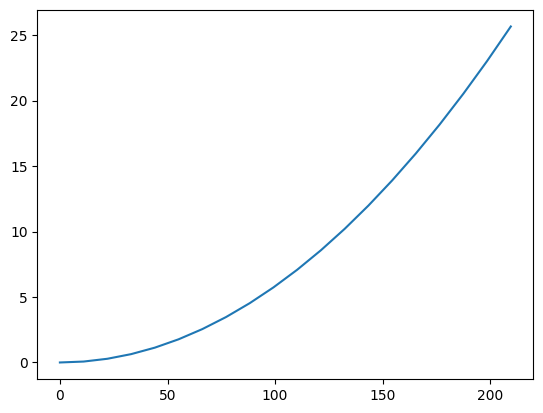

In [76]:
plt.plot(x0, z0)
plt.show()

In [77]:
q0=np.zeros(12*N)

In [78]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [79]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    RET = Ret(φ,θ,ψ)

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

    Z0 = tau_force[:3]    
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0.squeeze())
 
    A0 = Jrho(RET,Jrho0)
    A_fin = np.einsum('ijk,ikr->ijr',A0, Π(φ,θ,ψ))

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 
    
    H = np.cross(D,np.einsum('ijk,ik->ij', A0, D))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, C + G - L - H - np.einsum('ijk,ik->ij',A0, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [80]:
root_ = root(static_func, q0, method='df-sane')

In [81]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 1.985e+01  1.985e+01 ...  0.000e+00  0.000e+00]
       x: [ 2.760e+02  2.870e+02 ...  0.000e+00  0.000e+00]
     nit: 277
    nfev: 1000
  method: df-sane

In [82]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [83]:
# q0 = root_.x                                            # start from static solution

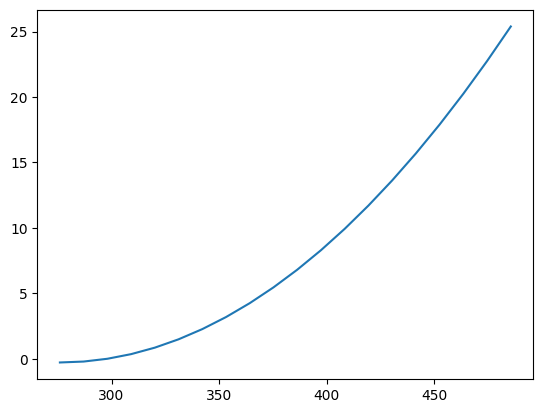

In [84]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [85]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [86]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = np.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [87]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [88]:
def FEA(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):

    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    glob_force = np.zeros(len(vessel_movement))


    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [89]:
# 10 The Space Frame Element - verification
d,f=FEA(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6)),
        bc_val=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4],
        vessel_movement=[ 0, 0, 0, 0, 0,0.0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [90]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06, -7.050e-06,  3.350e-06,  8.930e-06,  1.450e-06,
        1.750e-06,  1.140e-06, -1.230e-05,  4.280e-06,  1.418e-05,
        1.450e-06,  1.750e-06,  1.140e-06, -2.490e-06, -7.000e-08,
        8.380e-06,  1.450e-06,  1.750e-06,  1.140e-06])

In [91]:
f

array([ 2.18575158e-15, -1.86923231e-17, -3.84067778e-15,  9.71445147e-17,
        4.94078553e-17, -1.38777878e-17, -5.59719372e-16, -2.94360890e-17,
        2.29749217e-17,  3.06625927e-19,  2.51331616e-17,  5.88721780e-17,
        1.93123512e-17,  1.42708111e-17,  1.72398987e-15, -2.85416222e-17,
        6.63802780e-17, -6.09863722e-20,  2.08166817e-17,  4.64478987e-17,
        2.42861287e-17,  1.38777878e-17,  3.17637355e-20, -1.38777878e-17])

In [92]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=E, G=G, A=Ar, Iy=Iy_, Iz=Iz_, J=J_):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
    
    bc_node = list(range(3))+list(range((6*len(X)-6),6*len(X)))
    bc_val = [0]*3 + vessel_movement
    
    vessel_move=np.zeros(len(X)*6)

    d, f = FEA(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [93]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [94]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.06670570e-03,  1.11694336e-02, -2.33459473e-03],
       [ 2.20870972e-03,  3.50341797e-02, -2.62451172e-03],
       [ 6.94322586e-03,  3.28407288e-02,  5.78308105e-03],
       [-4.30822372e-04,  2.58789062e-02, -1.61018372e-02],
       [-2.22778320e-03,  5.61523438e-03,  1.86157227e-02],
       [ 2.25067139e-03, -7.20214844e-03, -1.41601562e-02],
       [-3.04794312e-03, -2.07138062e-02,  8.48388672e-03],
       [ 6.29997253e-03, -2.29492188e-02,  2.34603882e-03],
       [ 2.31933594e-03, -1.34277344e-02, -1.19628906e-02],
       [-9.68933105e-03, -9.15527344e-03,  2.09960938e-02],
       [ 7.78961182e-03,  9.30786133e-04, -2.35595703e-02],
       [ 2.09569931e-04,  1.35498047e-02,  2.14118958e-02],
       [-2.12860107e-03,  8.78906250e-03, -1.19628906e-02],
       [-2.79235840e-03,  8.91113281e-03, -4.88281250e-04],
       [ 3.45490598e-03,  1.35193911e-02,  1.00385064e-02],
       [ 3.67771439e-03,  3.62509478e-04

In [95]:
mom

array([[-1.95407867e-03, -1.38160586e-02,  1.83105469e-03],
       [-4.19998169e-03,  1.00097656e-02,  6.02722168e-04],
       [-1.45988464e-02, -2.86865234e-03, -1.22070312e-04],
       [-1.35498047e-02,  3.41796875e-03, -1.70898438e-03],
       [-1.02539062e-02, -2.74658203e-03,  9.76562500e-03],
       [-3.25775146e-03,  4.88281250e-04, -4.45556641e-03],
       [-1.46484375e-03, -7.06481934e-03, -8.30078125e-03],
       [ 6.82067871e-03,  2.44140625e-03,  4.88281250e-03],
       [ 1.14746094e-02,  2.26020813e-02, -2.44140625e-02],
       [ 9.97543335e-03,  1.22070312e-02, -9.70458984e-03],
       [ 3.96728516e-03,  1.52587891e-04,  1.75781250e-02],
       [-2.02941895e-03,  4.88281250e-03,  2.97851562e-02],
       [-4.27246094e-03,  4.12750244e-03,  1.46484375e-02],
       [-6.89697266e-03,  1.26953125e-02,  1.27563477e-02],
       [-2.92968750e-03, -6.38961792e-03, -9.76562500e-03],
       [-4.06304669e-03,  4.14849460e-03,  2.04985298e-05],
       [-2.38448926e-03, -7.75606344e-03

In [96]:
angle

array([[-3.79148707e-01,  2.45462799e-02, -4.15794642e-02],
       [-3.79148707e-01,  2.43479427e-02, -4.15793974e-02],
       [-3.78804362e-01,  2.37519592e-02, -4.15725691e-02],
       [-3.77771497e-01,  2.27562860e-02, -4.15390968e-02],
       [-3.75706276e-01,  2.13586805e-02, -4.14458494e-02],
       [-3.72265373e-01,  1.95566979e-02, -4.12464559e-02],
       [-3.67106137e-01,  1.73476896e-02, -4.08813179e-02],
       [-3.59886762e-01,  1.47288008e-02, -4.02776260e-02],
       [-3.50266449e-01,  1.16969678e-02, -3.93493792e-02],
       [-3.37905574e-01,  8.24891632e-03, -3.79974071e-02],
       [-3.22465843e-01,  4.38115827e-03, -3.61093968e-02],
       [-3.03610455e-01,  8.99897452e-05, -3.35599210e-02],
       [-2.81004255e-01, -4.62851177e-03, -3.02104702e-02],
       [-2.54313890e-01, -9.77849003e-03, -2.59094872e-02],
       [-2.23207954e-01, -1.53643127e-02, -2.04924042e-02],
       [-1.87357136e-01, -2.13905743e-02, -1.37816821e-02],
       [-1.46434363e-01, -2.78620990e-02

### Vessle Simulation

In [97]:
sampleTime = 0.01              # sample time [seconds]
Number = 60000                      # number of samples

In [98]:
Number*sampleTime

600.0

In [99]:
vehicle=semisub('DPcontrol',1,-1,0.0,0,0)

In [100]:
[simTime, simData] = simulate(Number, sampleTime, vehicle)

In [101]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

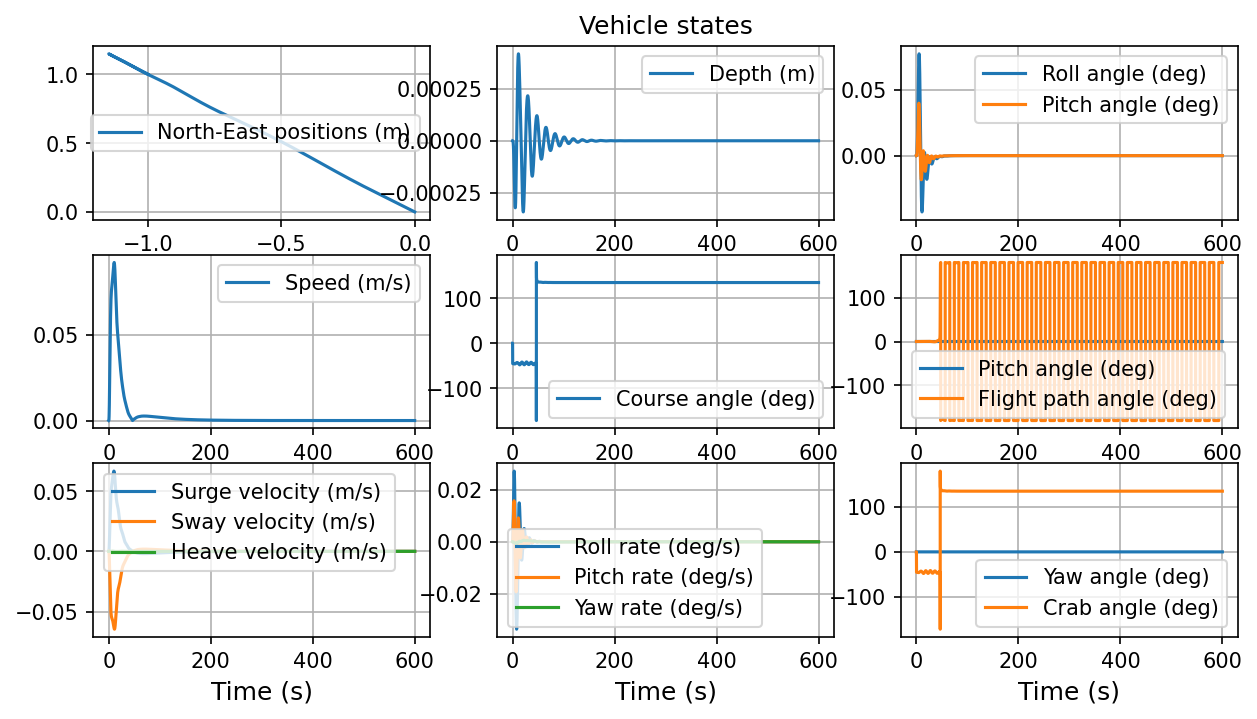

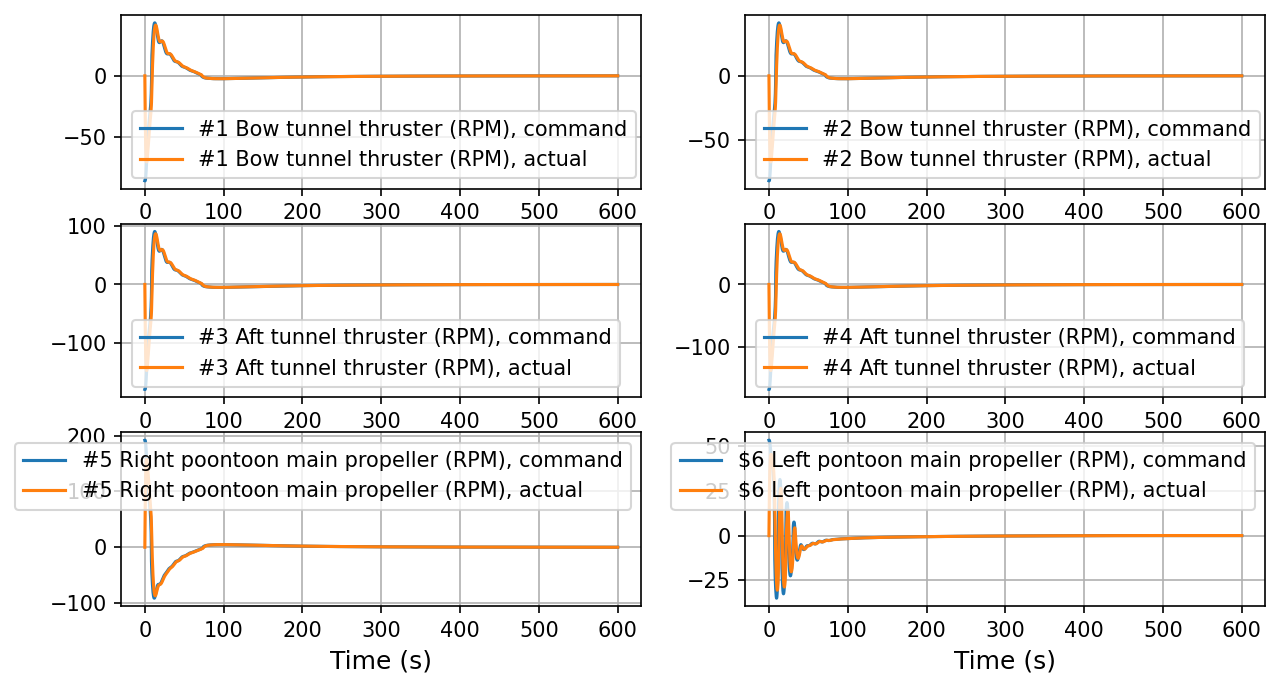

In [102]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [103]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

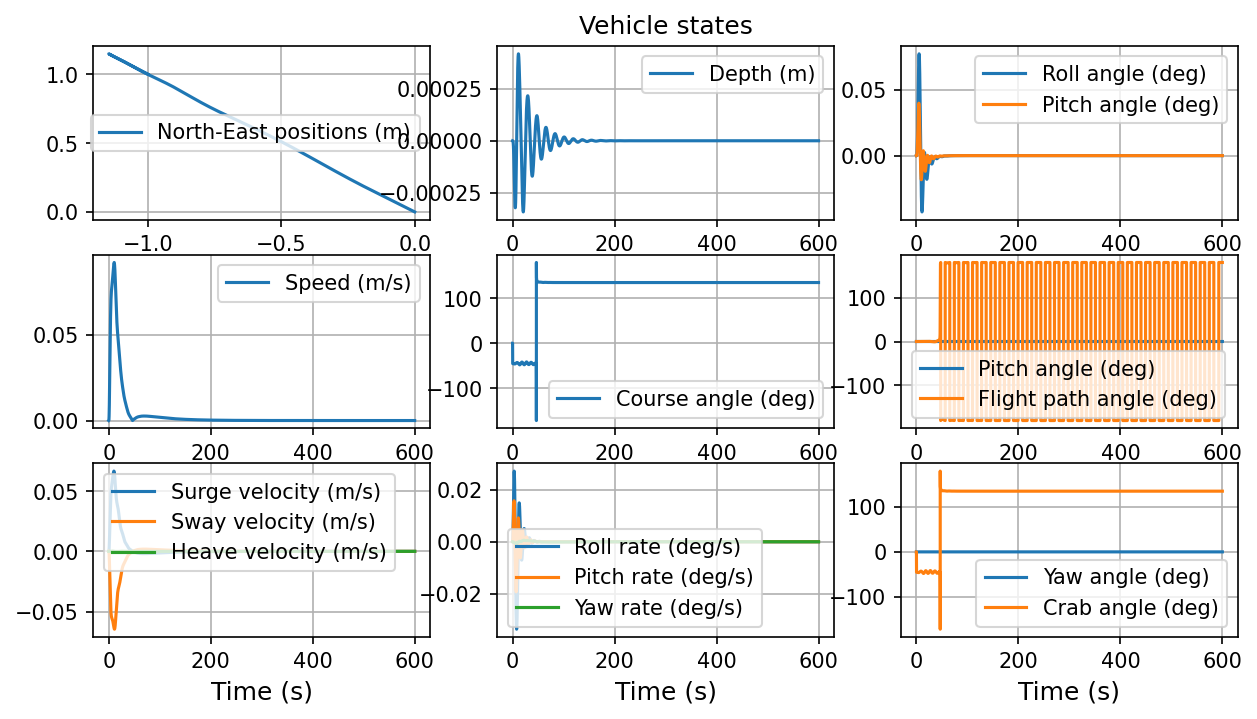

In [104]:
plotVehicleStates(simTime, simData, 3)

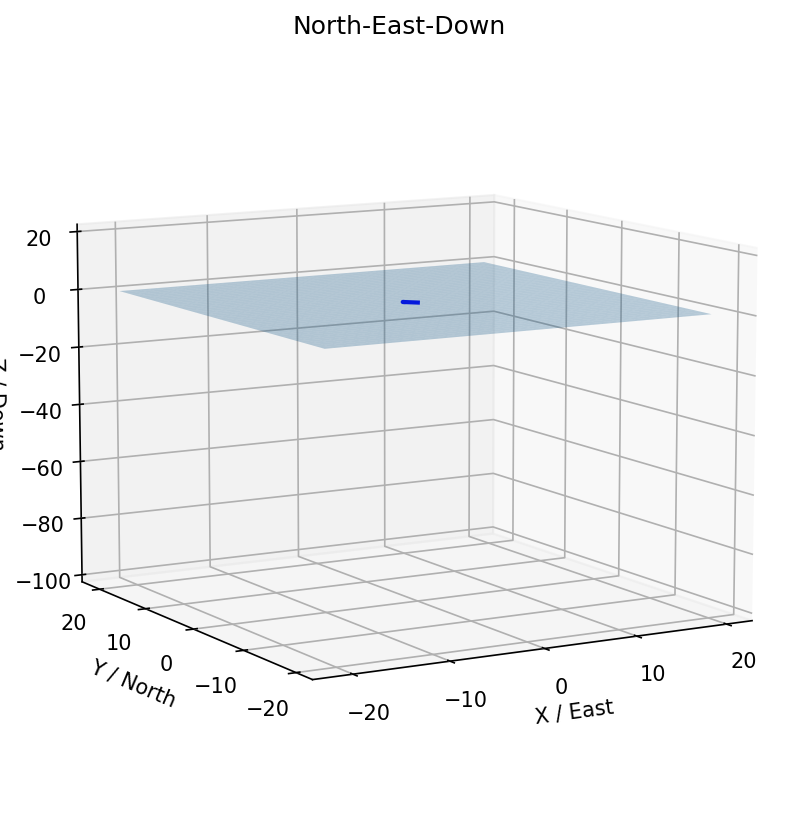

In [105]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [106]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [107]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.x_ve = 0
        self.y_ve = 0
        self.z_ve = 0
        self.phi_ve = 0
        self.theta_ve = 0
        self.psi_ve = 0
        self.top_tension = 0
        self.sagbend_strain = 0
        self.my_iter = 0

In [108]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())
    return np.array(ans)  

In [109]:
# V_rho=np.zeros(Jrho0.shape)
# np.fill_diagonal(V_rho, vessel_inertia)

In [110]:
# M_t=inert(vessel_mass*9.81,mp*9.81, x0)
# Jrho1=inert(V_rho, Jrho0, x0)

### Dynamics

In [111]:
def dynamic_func(t, Q, coefs, T, calibr):
    
    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    idx = find_nearest(np.array(ans_t),  t)
    
    del_t = idx-T.my_t
    if del_t<0:
        idx=T.my_t
        
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_ve = ssa(simData[:, 5][idx])
    
    RET = Ret(φ,θ,ψ)

    vessel_movement = np.zeros(6)
    
    
    vessel_movement[0] = (x_ve - T.x_ve)
    vessel_movement[1] = (y_ve - T.y_ve)
    vessel_movement[2] = (z_ve - T.z_ve)
    vessel_movement[3] = (phi_ve - T.phi_ve)
    vessel_movement[4] = (theta_ve - T.theta_ve)
    vessel_movement[5] = (psi_ve - T.psi_ve)

    vessel_movement/=calibr
    

    fors, mom, angle = PipeForce(x, y, z, list(vessel_movement), coefs)
    
    Z0 = fors.squeeze()
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T

    Z = (Z1 + Z2 - Z0)

############################################################
#     ddx,ddy, ddz = (Z/(M_t.reshape(-1, 1))).T
    ddx,ddy, ddz = (Z/Ws[0]).T    
############################################################
    
    C0 = np.einsum('ijk,ik->ij', Π(φ,θ,ψ), angle).squeeze()    
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0)


    A0 = Jrho(RET,Jrho0)
#     A0 = Jrho(RET,Jrho1) 
    A_fin = np.einsum('ijk,ikr->ijr', A0, Π(φ,θ,ψ))
    

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 

    H = np.cross(D, np.einsum('ijk,ik->ij', A0, D))
    

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, (C + G - L - H - np.einsum('ijk,ik->ij', A0, B))).T
#############################################

    T.my_t=idx
    T.x_ve=x_ve
    T.y_ve=y_ve
    T.z_ve=z_ve
    T.phi_ve = phi_ve
    T.theta_ve = theta_ve
    T.psi_ve = psi_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall-clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()   
         
    
    ans=np.concatenate([dx, ddx, 
                        dy, ddy, 
                        dz, ddz, 
                        dφ, ddφ, 
                        dθ, ddθ, 
                        dψ, ddψ
                       ], axis=0)
   
   
    if t>1:
        ax=np.einsum('ijk,ik->ij',np.linalg.inv(RET),ne(x, y, z, φ, θ, ψ))
        
        T.top_tension=max(T.top_tension, np.max(ax[-1,:]))
    
        ben=np.max(np.einsum('ijk,ik->ij',np.linalg.inv(RET), 
                         me(φ, θ, ψ, φ, θ, ψ)))/(mp*9.81*np.sqrt((x[-1]-x0_[-1])**2+
                                                                 (y[-1]-0)**2+(z[-1]-z0_[-1])**2)**2)

        I=3.14*(d0**4-dI**4)/64
        strain=np.max(ben)*d0/(2*E*I)    
        
        T.sagnend_strain=max(T.sagbend_strain, strain)
    T.my_iter+=1
    
    return ans

In [112]:
T_ = MyTime()

# initial conditions - to control dynamics
q0[6*N:7*N], q0[8*N:9*N], q0[10*N:11*N] = (np.array([0.01 for i in range(N)]),
                                          np.array([0.000001 for i in range(N)]),
                                          np.array([0.001257*i/N for i in range(N)]))

In [113]:
startTime1 = datetime.now()
us_ = solve_ivp(dynamic_func,
             tspan,
             q0,
             args=(coefs, T_, vessel_motion_calibration_coefficient,))
print(datetime.now() - startTime1)

Physical time:  9.451770412225489e-07  Iteration wall-clock time:  0:00:00.838521
Physical time:  1.0094233604209504  Iteration wall-clock time:  0:00:28.026063
Physical time:  2.0153904081846092  Iteration wall-clock time:  0:00:42.996660
Physical time:  3.0216639968591408  Iteration wall-clock time:  0:00:38.380665
Physical time:  4.0009375077094  Iteration wall-clock time:  0:00:21.794124
Physical time:  5.006279800316876  Iteration wall-clock time:  0:00:22.271869
Physical time:  6.048811507692121  Iteration wall-clock time:  0:00:23.283828
Physical time:  7.000738077095445  Iteration wall-clock time:  0:00:23.093324
Physical time:  8.042645329866392  Iteration wall-clock time:  0:00:22.468506
Physical time:  9.010241900844902  Iteration wall-clock time:  0:00:22.682722
Physical time:  10.008068105191873  Iteration wall-clock time:  0:00:30.111393
Physical time:  11.00706129403256  Iteration wall-clock time:  0:00:29.249461
0:05:33.893367


In [114]:
# max axial tension
T_.top_tension

1030622.0632682225

In [115]:
# max bending strain
T_.sagnend_strain*(mp*9.81*np.sqrt((x[-1]-x0_[-1])**2+(y[-1]-0)**2+(z[-1]-z0_[-1])**2)**2)

0.00026257829966260486

### Results

In [116]:
fin=us_

In [117]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  9.452e-05 ...  1.193e+01  1.200e+01]
        y: [[ 0.000e+00  1.357e-22 ...  4.231e-05  4.268e-05]
            [ 1.103e+01  1.103e+01 ...  1.076e+01  1.076e+01]
            ...
            [ 0.000e+00 -1.203e-19 ...  3.246e-10  3.193e-10]
            [ 0.000e+00 -8.939e-20 ...  1.647e-11  1.601e-11]]
      sol: None
 t_events: None
 y_events: None
     nfev: 698
     njev: 0
      nlu: 0

In [118]:
t=fin.t

In [119]:
fin=fin.y.T

In [120]:
t.shape, fin.shape

((110,), (110, 240))

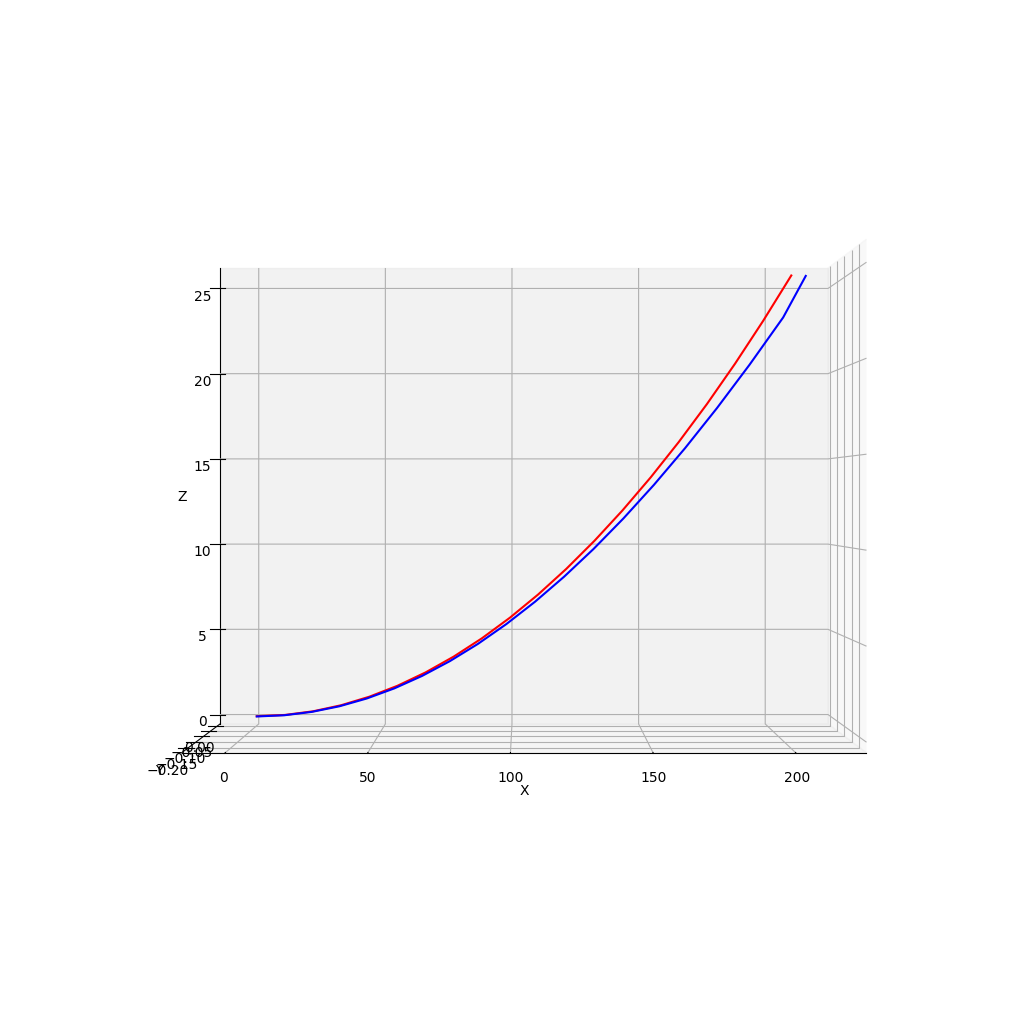

In [121]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,N)]]
Y0=fin[0,[i for i in range(2*N,3*N)]]
Z0=fin[0,[i for i in range(4*N,5*N)]]

j=-1
X=fin[j,[i for i in range(0,N)]]
Y=fin[j,[i for i in range(2*N,3*N)]]
Z=fin[j,[i for i in range(4*N,5*N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [122]:
X,Y,Z

(array([4.26811393e-05, 1.07583706e+01, 2.15844918e+01, 3.24470588e+01,
        4.33332434e+01, 5.42367960e+01, 6.51544917e+01, 7.60847523e+01,
        8.70270172e+01, 9.79814630e+01, 1.08948794e+02, 1.19929846e+02,
        1.30925675e+02, 1.41937435e+02, 1.52965727e+02, 1.64010604e+02,
        1.75069560e+02, 1.86139407e+02, 1.97215557e+02, 2.04297528e+02]),
 array([ 4.26092149e-09,  5.40259319e-04, -7.27351810e-04, -3.58313090e-03,
        -7.82484047e-03, -1.33600736e-02, -2.01726698e-02, -2.82759411e-02,
        -3.76890321e-02, -4.84290464e-02, -6.05095238e-02, -7.39409341e-02,
        -8.87314122e-02, -1.04889190e-01, -1.22421115e-01, -1.41331329e-01,
        -1.61620947e-01, -1.83290091e-01, -2.06339336e-01, -2.26579885e-01]),
 array([-1.73383154e-02,  5.00287183e-02,  2.53114460e-01,  5.92886530e-01,
         1.06988525e+00,  1.68439702e+00,  2.43660563e+00,  3.32667721e+00,
         4.35479608e+00,  5.52118254e+00,  6.82610131e+00,  8.26984829e+00,
         9.85276013e+00,  1.

In [123]:
X0,Y0,Z0

(array([  0.        ,  11.02712714,  22.05425428,  33.08138141,
         44.10850855,  55.13563569,  66.16276283,  77.18988997,
         88.21701711,  99.24414424, 110.27127138, 121.29839852,
        132.32552566, 143.3526528 , 154.37977994, 165.40690707,
        176.43403421, 187.46116135, 198.48828849, 209.51541563]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([ 0.        ,  0.07074654,  0.28299779,  0.63678871,  1.13217754,
         1.76924585,  2.54809852,  3.46886379,  4.53169324,  5.73676187,
         7.08426809,  8.57443374, 10.20750417, 11.98374825, 13.90345843,
        15.96695076, 18.17456499, 20.52666459, 23.02363679, 25.66589272]))

In [124]:
us=fin.T

In [125]:
us.shape

(240, 110)

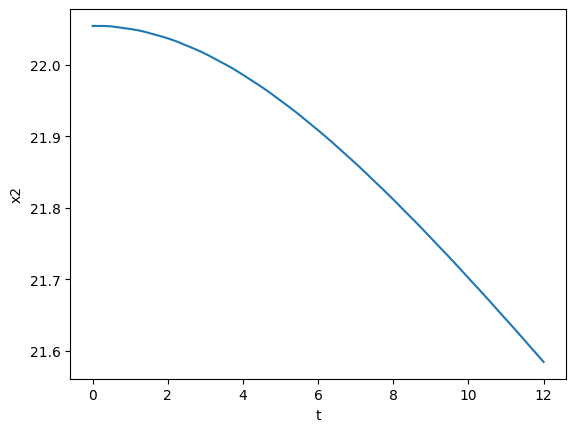

In [126]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

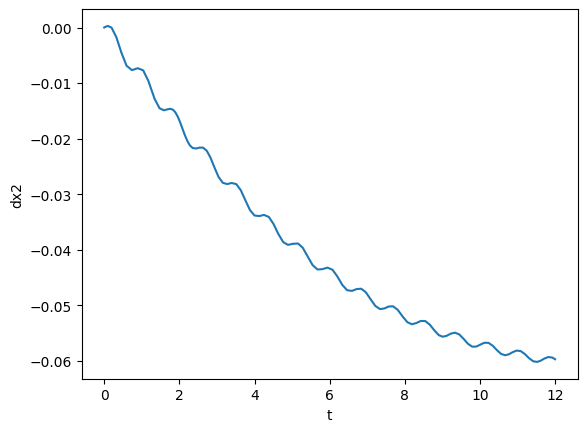

In [127]:
plt.plot(t,us.T[:,N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

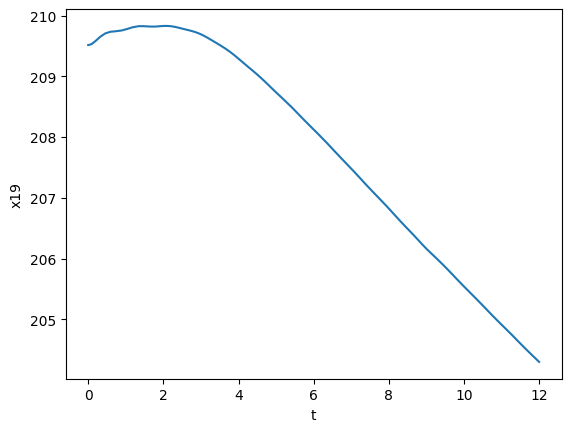

In [128]:
plt.plot(t,us.T[:,N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x{}'.format(N-1))
plt.show()

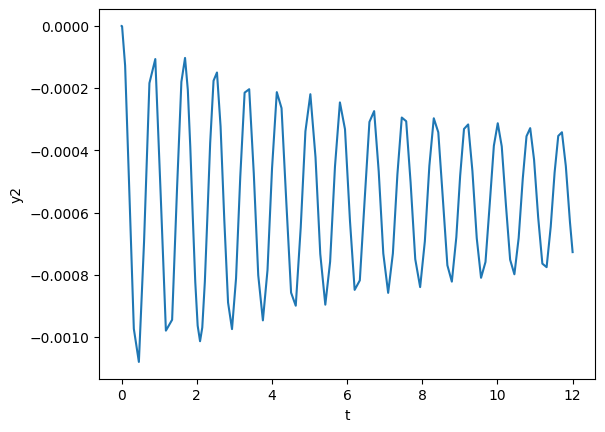

In [129]:
plt.plot(t,us.T[:,2*N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

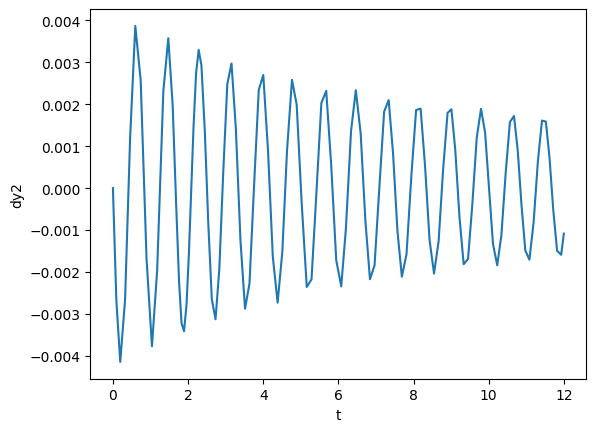

In [130]:
plt.plot(t,us.T[:,3*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

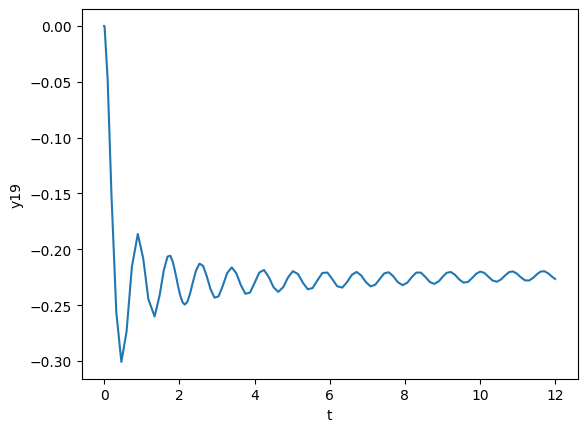

In [131]:
plt.plot(t,us.T[:,2*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('y{}'.format(N-1))
plt.show()

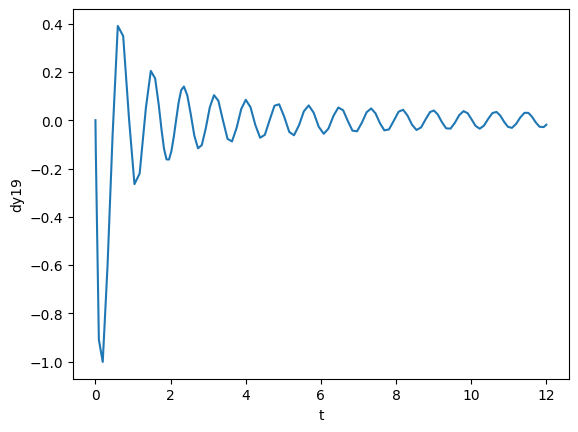

In [132]:
plt.plot(t,us.T[:,3*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('dy{}'.format(N-1))
plt.show()

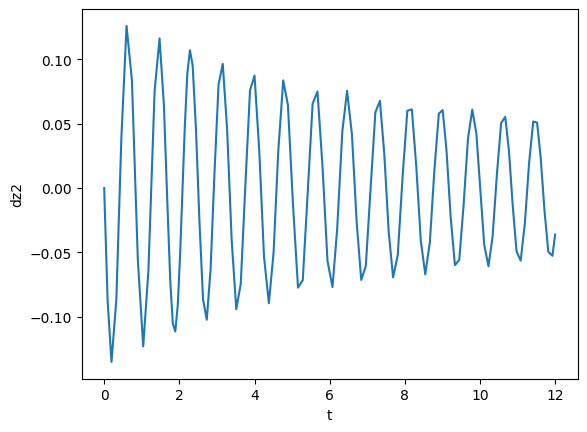

In [133]:
plt.plot(t,us.T[:,5*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

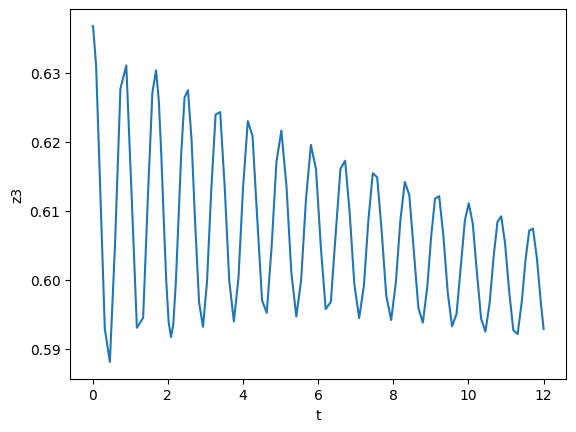

In [134]:
plt.plot(t,us.T[:,4*N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

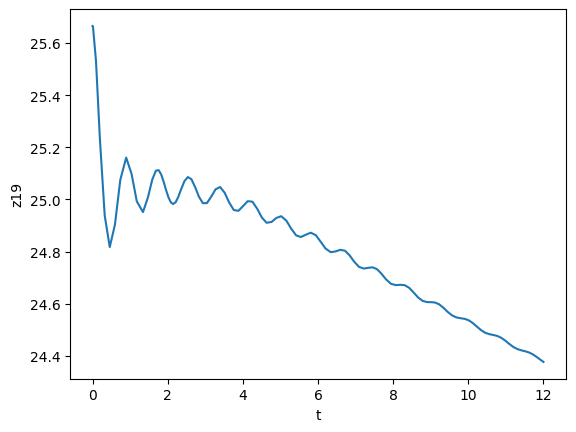

In [135]:
plt.plot(t,us.T[:,4*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('z{}'.format(N-1))
plt.show()

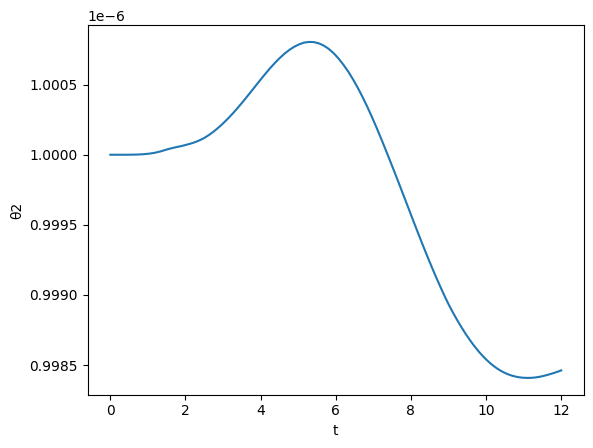

In [136]:
plt.plot(t,us.T[:,8*N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

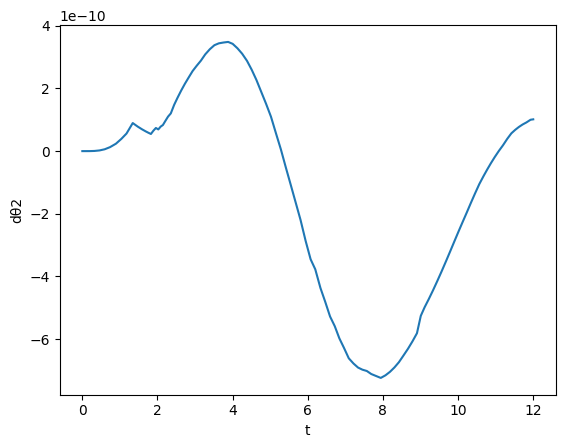

In [137]:
plt.plot(t,us.T[:,9*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

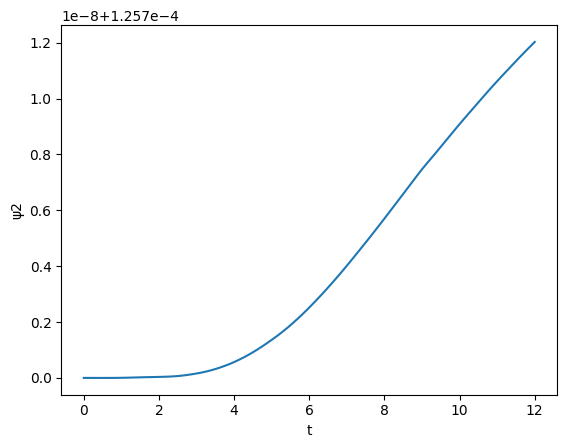

In [138]:
plt.plot(t,us.T[:,10*N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

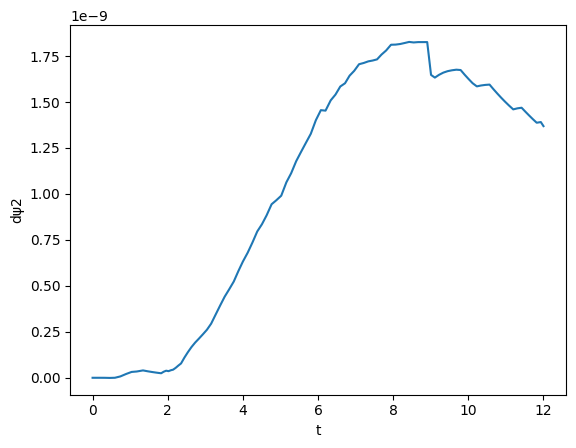

In [139]:
plt.plot(t,us.T[:,11*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

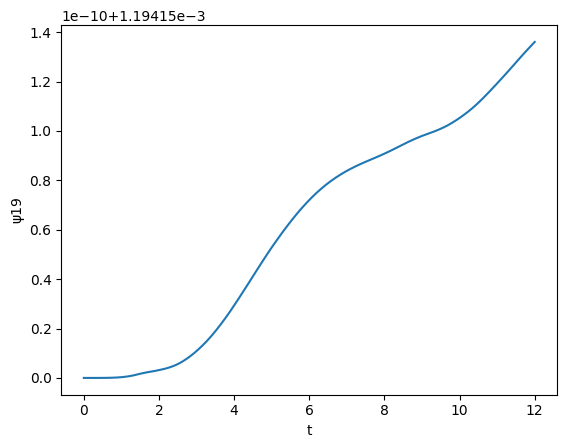

In [140]:
plt.plot(t,us.T[:,10*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('ψ{}'.format(N-1))
plt.show()

In [141]:
X010=us.T[:,0*N:1*N]

In [142]:
Y010=us.T[:,2*N:3*N]

In [143]:
Z010=us.T[:,4*N:5*N]

In [144]:
# simulation = np.stack([X010,Y010,Z010],axis=2) 

# FPS = 30                      
# frame_duration = 1000 / FPS

# frames = []
# for t in range(simulation.shape[0]):
#     x = simulation[t,:,0]
#     y = simulation[t,:,1]
#     z = simulation[t,:,2]

#     frames.append(go.Frame(
#         data=[
#             go.Scatter3d(
#                 x=x, y=y, z=z,
#                 mode="lines+markers",
#                 marker=dict(size=5, color=list(range(12)), colorscale="Viridis"),
#                 line=dict(width=4)
#             )
#         ],
#         name=f"t={t}"
#     ))

# # First frame
# x0, y0, z0 = simulation[0,:,0], simulation[0,:,1], simulation[0,:,2]

# fig = go.Figure(
#     data=[go.Scatter3d(x=x0, y=y0, z=z0, mode="lines+markers")],
#     frames=frames
# )

# # Animation controls
# fig.update_layout(
#     title="Pipeline Simulation ",
#     scene=dict(
#         xaxis_title="X",
#         yaxis_title="Y",
#         zaxis_title="Z",
#         xaxis=dict(range=[0, 300]),
#         yaxis=dict(range=[-50, 50]),
#         zaxis=dict(range=[0, 40]),
#         aspectmode="data",
       
#     ),
#     updatemenus=[{
#         "type": "buttons",
#         "buttons": [
#             {
#                 "label": "Play",
#                 "method": "animate",
#                 "args": [None, {"frame": {"duration": frame_duration, "redraw": True}}]
#             },
#             {
#                 "label": "Pause",
#                 "method": "animate",
#                 "args": [[None], {"frame": {"duration": 0}}]
#             }
#         ]
#     }]
# )

# fig.show()